**Task 1 was skipped due to 6000 level only**

**Task 2 Part 1 (10 Points):** We will use a weather dataset (time-series) to demonstrate the usage of
Recurrent Neural Networks (RNNs). In particular, we will focus on predicting
future weather attributes (e.g., temperature) based on historical patterns.

**Why sequence models (RNNs)?**
Weather data has a strong temporal component: measurements at one time step
depend on previous time steps. RNNs (and their variants like LSTMs and GRUs)
are well-suited for capturing these temporal dependencies via a hidden state
that evolves over time.

**Dataset:**
We are using a publicly available weather dataset from ([Kaggle Weather Dataset](https://www.kaggle.com/datasets/muthuj7/weather-dataset))

**Objective:**
- Predict the next day’s temperature from the past 7 days (or any chosen window size).
- Evaluate performance on both a validation set and a test set using MSE/MAE.

**Framework Choice:** TensorFlow/Keras
- We'll implement an RNN (specifically an LSTM) for our weather prediction model
using the Keras API.

**Data Formatting and CSV Structure**

The weather dataset we are using is in a CSV (comma-separated values) file. Each row corresponds to a specific time (in this case, hourly records). Below is an example of a few rows from the dataset:

| Formatted Date                  | Summary         | Precip Type | Temperature (C) | Apparent Temperature (C) | Humidity | Wind Speed (km/h) | Wind Bearing (degrees) | Visibility (km) | Loud Cover | Pressure (millibars) | Daily Summary                       |
|--------------------------------|-----------------|-------------|-----------------|--------------------------|----------|-------------------|------------------------|-----------------|-----------|----------------------|--------------------------------------|
| 2006-04-01 00:00:00.000 +0200  | Partly Cloudy   | rain        | 9.472222        | 7.388889                 | 0.89     | 14.1197           | 251.0                  | 15.8263         | 0.0       | 1015.13             | Partly cloudy throughout the day.    |
| 2006-04-01 01:00:00.000 +0200  | Partly Cloudy   | rain        | 9.355556        | 7.227778                 | 0.86     | 14.2646           | 259.0                  | 15.8263         | 0.0       | 1015.63             | Partly cloudy throughout the day.    |
| 2006-04-01 02:00:00.000 +0200  | Mostly Cloudy   | rain        | 9.377778        | 9.377778                 | 0.89     | 3.9284            | 204.0                  | 14.9569         | 0.0       | 1015.94             | Partly cloudy throughout the day.    |
| 2006-04-01 03:00:00.000 +0200  | Partly Cloudy   | rain        | 8.288889        | 5.944444                 | 0.83     | 14.1036           | 269.0                  | 15.8263         | 0.0       | 1016.41             | Partly cloudy throughout the day.    |
| 2006-04-01 04:00:00.000 +0200  | Mostly Cloudy   | rain        | 8.755556        | 6.977778                 | 0.83     | 11.0446           | 259.0                  | 15.8263         | 0.0       | 1016.51             | Partly cloudy throughout the day.    |

Here is a description of each column:
- **Formatted Date:** A timestamp specifying the exact date and time (including timezone).
- **Summary:** A short textual description of the weather conditions (e.g., "Partly Cloudy").
- **Precip Type:** Indicates the type of precipitation (e.g., "rain", "snow", or null if none).
- **Temperature (C):** The measured temperature in degrees Celsius.
- **Apparent Temperature (C):** The "feels-like" temperature, accounting for factors like wind.
- **Humidity:** The relative humidity, typically ranging from 0.0 (no moisture) to 1.0 (saturated).
- **Wind Speed (km/h):** How fast the wind is blowing, measured in kilometers per hour.
- **Wind Bearing (degrees):** The compass direction the wind is coming from, in degrees (0-360).
- **Visibility (km):** The average distance one can see, in kilometers.
- **Loud Cover / Cloud Cover:** (Possibly a typo in some datasets) This represents the fraction of the sky covered by clouds. A value of 0.0 means no cloud cover, and 1.0 would mean completely overcast.
- **Pressure (millibars):** The atmospheric pressure in millibars.
- **Daily Summary:** A longer textual description summarizing the overall daily weather pattern.

In this assignment, we will clean, scale, and transform the relevant columns
into training sequences. Then we will train, validate, and test an LSTM or
other RNN architecture to forecast future temperature values.

In [42]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TensorFlow version:",tf.__version__)
print("Libraries imported")

TensorFlow version: 2.18.0
Libraries imported


In [43]:
data_path = 'weatherHistory.csv'
df = pd.read_csv(data_path)

df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


We'll check for missing values, decide how to handle them, and ensure
the date/time column is in datetime format if we plan to use it.
For our sequence modeling, we mainly need the numerical columns
(Temperature, Humidity, etc.).

In [9]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

Missing values in each column:
Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00+02:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


We’ll select the columns we want to use as features and the column we plan to predict.
For simplicity, let's choose:

- Temperature (C), Humidity, and Pressure (millibars) as input features.
- Temperature (C) as our target.

We scale these features using MinMaxScaler, which typically helps RNNs
train more efficiently.

In [10]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ['Temperature (C)', 'Humidity', 'Pressure (millibars)']
target_col = 'Temperature (C)'

scaler = MinMaxScaler(feature_range=(0, 1))
df[feature_cols] = scaler.fit_transform(df[feature_cols])

df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00+02:00,Partly Cloudy,rain,0.506975,7.388889,0.89,14.1197,251.0,15.8263,0.0,0.970135,Partly cloudy throughout the day.
1,2006-04-01 01:00:00+02:00,Partly Cloudy,rain,0.505085,7.227778,0.86,14.2646,259.0,15.8263,0.0,0.970613,Partly cloudy throughout the day.
2,2006-04-01 02:00:00+02:00,Mostly Cloudy,rain,0.505445,9.377778,0.89,3.9284,204.0,14.9569,0.0,0.970909,Partly cloudy throughout the day.
3,2006-04-01 03:00:00+02:00,Partly Cloudy,rain,0.487805,5.944444,0.83,14.1036,269.0,15.8263,0.0,0.971358,Partly cloudy throughout the day.
4,2006-04-01 04:00:00+02:00,Mostly Cloudy,rain,0.495365,6.977778,0.83,11.0446,259.0,15.8263,0.0,0.971454,Partly cloudy throughout the day.


We will create sequences of length 'window_size' to use as input (X).
For example, if window_size=7, the model sees 7 consecutive hourly
data points, and it tries to predict the Temperature (C) at the
8th time step.

In [11]:
def create_sequences(data, target, window_size=7):
    """
    Returns:
      X: array of shape (num_samples, window_size, num_features)
      y: array of shape (num_samples,)
    """
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

# Convert our DataFrame to numpy arrays
input_data = df[feature_cols].values
target_data = df[target_col].values

# Create sequences
window_size = 7
X, y = create_sequences(input_data, target_data, window_size)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (95929, 7, 3)
Shape of y: (95929,)


We'll split the data into 80% training, 10% validation, and 10% testing.
This ensures we can monitor validation performance during training
and then check final performance on a held-out test set.

In [13]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("Train set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (76743, 7, 3) (76743,)
Validation set size: (9592, 7, 3) (9592,)
Test set size: (9594, 7, 3) (9594,)


We’ll build a simple LSTM model in Keras:

1. Input layer (shape = (window_size, number_of_features)).
2. LSTM layer with 64 units (default activation = 'tanh').
3. Dense output layer with 1 unit (for predicting Temperature).

We’ll compile the model with:
- Loss = 'mse'
- Optimizer = 'adam'
- Metrics = ['mae', 'mse']

In [14]:
model = keras.Sequential([
    layers.Input(shape=(window_size, len(feature_cols))),
    layers.LSTM(64, activation='tanh', return_sequences=False),
    layers.Dense(1)  # Single output for Temperature prediction
])

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'mse']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

We now train the model for a certain number of epochs (e.g., 20) and a
batch size of 32. We also monitor validation loss to see if the model
is overfitting or underfitting.

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0045 - mae: 0.0401 - mse: 0.0045 - val_loss: 5.3141e-04 - val_mae: 0.0157 - val_mse: 5.3141e-04
Epoch 2/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 6.4844e-04 - mae: 0.0177 - mse: 6.4844e-04 - val_loss: 4.1385e-04 - val_mae: 0.0145 - val_mse: 4.1385e-04
Epoch 3/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 5.7854e-04 - mae: 0.0162 - mse: 5.7854e-04 - val_loss: 4.0469e-04 - val_mae: 0.0144 - val_mse: 4.0469e-04
Epoch 4/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 5.6575e-04 - mae: 0.0159 - mse: 5.6575e-04 - val_loss: 3.7641e-04 - val_mae: 0.0133 - val_mse: 3.7641e-04
Epoch 5/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 5.5656e-04 - mae: 0.0157 - mse: 5.5656e-04 - val_loss: 3.7081e-04 - val_mae: 0.0130 - val_mse: 3.7081e-04
Epoch 6/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 5.5006e-04 - mae: 0.0156 - mse: 5.5006e-04 - val_loss: 3.7461e-04 - val_mae: 0.0128 - val_mse: 3.746

We'll visualize how the MSE and MAE changed over epochs, then evaluate
on the test set. Finally, we calculate RMSE for a more intuitive
temperature error metric.

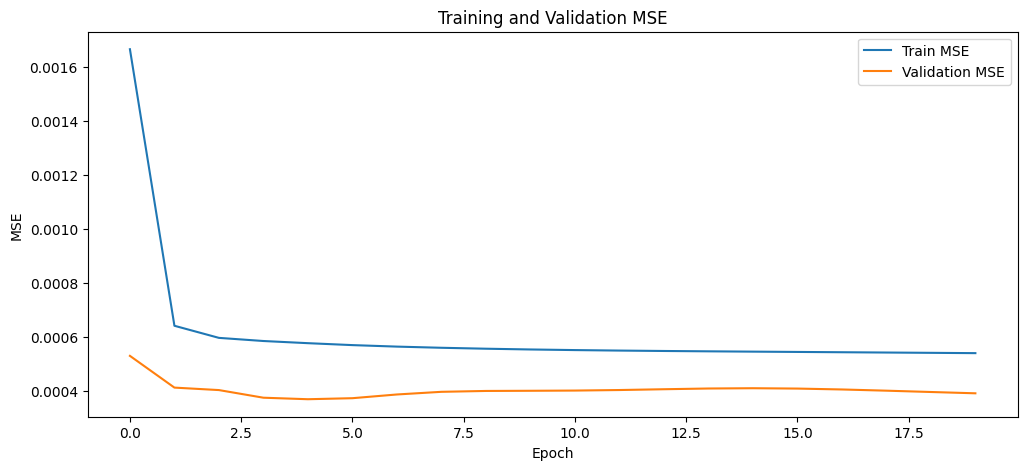

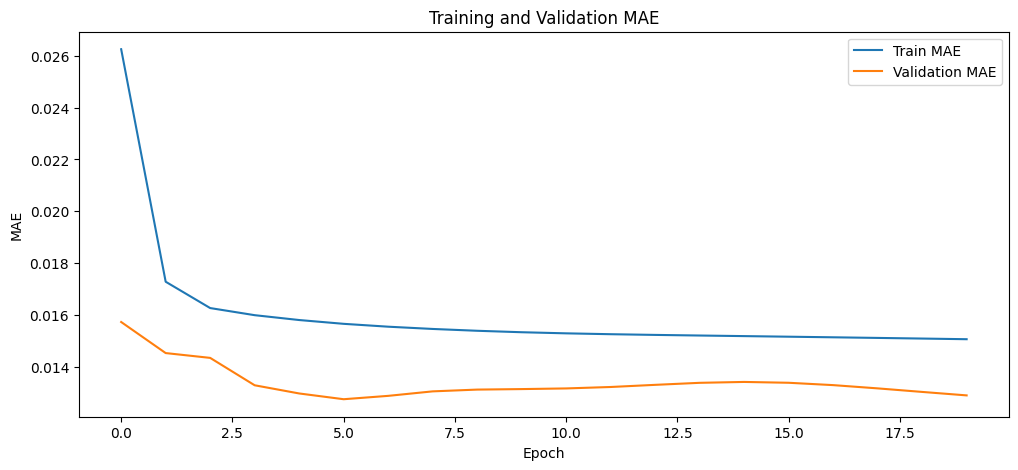

In [16]:
# Plot training and validation MSE
plt.figure(figsize=(12,5))
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [17]:
# Final evaluation on the test set
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Calculate RMSE
test_rmse = np.sqrt(test_mse)
print(f"Test RMSE: {test_rmse}")

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9612e-04 - mae: 0.0131 - mse: 3.9612e-04
Test MSE: 0.00037399434950202703
Test MAE: 0.012630365788936615
Test RMSE: 0.01933893351511471


**Conclusion and Insights**

Based on the final training, validation, and test performance:

- **Final Training Loss (MSE)** reached around `5.1791e-04`, and **Validation Loss (MSE)** settled around `3.9273e-04`.  
- The final **Test MSE** is approximately `3.9612e-04`. Converting this to RMSE, we get about `0.0193`.  
- The **Test MAE** is around `0.0126`.

These metrics indicate the model is making fairly small errors when predicting normalized temperature values. Since we used scaling (MinMaxScaler), the predicted values are on the same normalized scale. If we invert the scaling, we could see exactly how many degrees Celsius (on average) this corresponds to in real-world terms. However, even on the normalized scale, an MSE in the order of `1e-4` and an RMSE around `0.019` suggest the model is learning temporal patterns well, without suffering major overfitting (the training and validation curves are fairly close after 20 epochs).

**Interpretation & Potential Next Steps:**
1. **Good Fit**: The small gap between training and validation loss implies we are not severely overfitting. The test error is also close to the validation error, indicating good generalization.
2. **Model Complexity**: With a single LSTM layer (64 units) and a Dense output, the network is relatively straightforward. You might explore deeper or stacked LSTMs for potentially improved performance, or simpler architectures if you want faster training.
3. **Hyperparameter Tuning**: Experimenting with window size, number of LSTM units, or different learning rates could yield better results.
4. **Feature Engineering**: Adding more weather features (e.g., wind speed, precipitation) or time-based features (e.g., month, hour) might help the model capture more complex patterns.
5. **Inverse Scaling**: To interpret the actual temperature error in Celsius, run an inverse transform on predictions and compare them with the true temperature values directly.

Overall, these results show that the model has captured the time-series structure of the weather data successfully, as indicated by the low error metrics and consistent learning curves.

**Task 2 Part 2 (30 Points):**  
We previously built a sequence model for weather forecasting using an LSTM.
Now, we will:
1. Compare a basic RNN (SimpleRNN),
2. The LSTM model, and
3. A GRU-based model,

all trained on the same preprocessed weather data from Part 1.


**Key Points:**  
- We will use the same training/validation/test splits, same data preprocessing,
  and same hyperparameters (where applicable) to keep the comparison fair.
- We will provide performance visualization of the loss curves and final metrics
  for each model.

We'll define a very simple RNN using Keras's SimpleRNN layer. This is often
used as a baseline for comparison with LSTM/GRU models. We'll keep:
- window_size = 7 (same as before),
- a single SimpleRNN layer with 64 units,
- a Dense output layer with 1 unit for temperature prediction.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Build Simple RNN model
model_rnn = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model_rnn.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'mse']
)

model_rnn.summary()

# Train
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0027 - mae: 0.0309 - mse: 0.0027 - val_loss: 5.9092e-04 - val_mae: 0.0189 - val_mse: 5.9092e-04
Epoch 2/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 6.7135e-04 - mae: 0.0183 - mse: 6.7135e-04 - val_loss: 4.4412e-04 - val_mae: 0.0143 - val_mse: 4.4412e-04
Epoch 3/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 6.0372e-04 - mae: 0.0167 - mse: 6.0372e-04 - val_loss: 3.8867e-04 - val_mae: 0.0128 - val_mse: 3.8867e-04
Epoch 4/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.9809e-04 - mae: 0.0165 - mse: 5.9809e-04 - val_loss: 3.8729e-04 - val_mae: 0.0134 - val_mse: 3.8729e-04
Epoch 5/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.9508e-04 - mae: 0.0165 - mse: 5.9508e-04 - val_loss: 4.0387e-04 - val_mae: 0.0142 - val_mse: 4.0387e-04
Epoch 6/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 5.8691e-04 - mae: 0.0163 - mse: 5.8691e-04 - val_loss: 3.8423e-04 - val_mae: 0.0136 - val_mse: 3.8423e

We'll use the Keras LSTM layer again with 64 units. The key difference
from SimpleRNN is the internal gating mechanisms (input, output, and forget gates),
which help the LSTM handle long-term dependencies and mitigate the vanishing
gradient problem.

In [24]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model_lstm.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'mse']
)

model_lstm.summary()

# Train
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0088 - mae: 0.0489 - mse: 0.0088 - val_loss: 5.5545e-04 - val_mae: 0.0169 - val_mse: 5.5545e-04
Epoch 2/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 6.7785e-04 - mae: 0.0182 - mse: 6.7785e-04 - val_loss: 4.2335e-04 - val_mae: 0.0147 - val_mse: 4.2335e-04
Epoch 3/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 5.7896e-04 - mae: 0.0163 - mse: 5.7896e-04 - val_loss: 3.9484e-04 - val_mae: 0.0140 - val_mse: 3.9484e-04
Epoch 4/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 5.6369e-04 - mae: 0.0159 - mse: 5.6369e-04 - val_loss: 3.7581e-04 - val_mae: 0.0132 - val_mse: 3.7581e-04
Epoch 5/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 5.5522e-04 - mae: 0.0157 - mse: 5.5522e-04 - val_loss: 3.7621e-04 - val_mae: 0.0128 - val_mse: 3.7621e-04
Epoch 6/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 5.4891e-04 - mae: 0.0156 - mse: 5.4891e-04 - val_loss: 3.9270e-04 - val_mae: 0.0130 - val_mse: 3.927

Finally, we'll define a GRU-based model. A GRU (Gated Recurrent Unit)
is similar to an LSTM but uses fewer gates (reset and update gates)
and has a somewhat simpler internal architecture. It often trains
faster than an LSTM and can perform similarly or better on certain tasks.

In [25]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model_gru.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae', 'mse']
)

model_gru.summary()

# Train
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 64)                  │          13,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0038 - mae: 0.0340 - mse: 0.0038 - val_loss: 4.3086e-04 - val_mae: 0.0147 - val_mse: 4.3086e-04
Epoch 2/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 5.9648e-04 - mae: 0.0167 - mse: 5.9648e-04 - val_loss: 4.0708e-04 - val_mae: 0.0144 - val_mse: 4.0708e-04
Epoch 3/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 5.7710e-04 - mae: 0.0162 - mse: 5.7710e-04 - val_loss: 4.0903e-04 - val_mae: 0.0145 - val_mse: 4.0903e-04
Epoch 4/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 5.6747e-04 - mae: 0.0160 - mse: 5.6747e-04 - val_loss: 3.8017e-04 - val_mae: 0.0135 - val_mse: 3.8017e-04
Epoch 5/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 5.5797e-04 - mae: 0.0158 - mse: 5.5797e-04 - val_loss: 3.6961e-04 - val_mae: 0.0131 - val_mse: 3.6961e-04
Epoch 6/20
2399/2399 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 5.4997e-04 - mae: 0.0157 - mse: 5.4997e-04 - val_loss: 3.6794e-04 - val_mae: 0.0130 - val_mse: 3.679

Now we'll compare how these three models trained, focusing on metrics such as MSE or MAE.
We'll also evaluate each model on the test set to see which yields the best final performance.

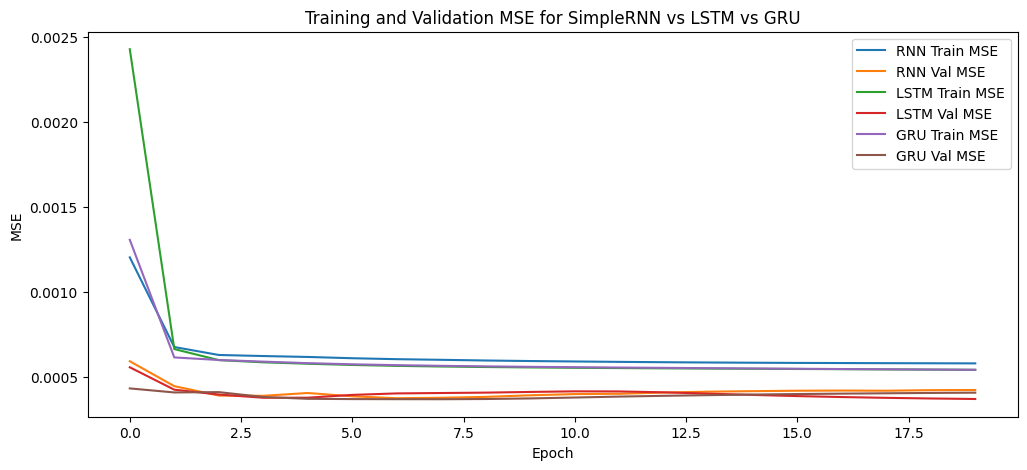

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history_rnn.history['mse'], label='RNN Train MSE')
plt.plot(history_rnn.history['val_mse'], label='RNN Val MSE')

plt.plot(history_lstm.history['mse'], label='LSTM Train MSE')
plt.plot(history_lstm.history['val_mse'], label='LSTM Val MSE')

plt.plot(history_gru.history['mse'], label='GRU Train MSE')
plt.plot(history_gru.history['val_mse'], label='GRU Val MSE')

plt.title('Training and Validation MSE for SimpleRNN vs LSTM vs GRU')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [27]:
# Evaluate each model on the test set
print("Evaluating SimpleRNN model:")
test_loss_rnn, test_mae_rnn, test_mse_rnn = model_rnn.evaluate(X_test, y_test)
test_rmse_rnn = (test_mse_rnn**0.5)

print(f"RNN Test MSE: {test_mse_rnn}")
print(f"RNN Test MAE: {test_mae_rnn}")
print(f"RNN Test RMSE: {test_rmse_rnn}\n")

print("Evaluating LSTM model:")
test_loss_lstm, test_mae_lstm, test_mse_lstm = model_lstm.evaluate(X_test, y_test)
test_rmse_lstm = (test_mse_lstm**0.5)

print(f"LSTM Test MSE: {test_mse_lstm}")
print(f"LSTM Test MAE: {test_mae_lstm}")
print(f"LSTM Test RMSE: {test_rmse_lstm}\n")

print("Evaluating GRU model:")
test_loss_gru, test_mae_gru, test_mse_gru = model_gru.evaluate(X_test, y_test)
test_rmse_gru = (test_mse_gru**0.5)

print(f"GRU Test MSE: {test_mse_gru}")
print(f"GRU Test MAE: {test_mae_gru}")
print(f"GRU Test RMSE: {test_rmse_gru}")

Evaluating SimpleRNN model:
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1619e-04 - mae: 0.0136 - mse: 4.1619e-04
RNN Test MSE: 0.0003932346007786691
RNN Test MAE: 0.0130736343562603
RNN Test RMSE: 0.01983014374074654

Evaluating LSTM model:
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7219e-04 - mae: 0.0127 - mse: 3.7219e-04
LSTM Test MSE: 0.00034952451824210584
LSTM Test MAE: 0.012208573520183563
LSTM Test RMSE: 0.018695574830480764

Evaluating GRU model:
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0865e-04 - mae: 0.0134 - mse: 4.0865e-04
GRU Test MSE: 0.00038620023406110704
GRU Test MAE: 0.012897929176688194
GRU Test RMSE: 0.019651977866390627


**Conclusion (Comparing SimpleRNN, LSTM, and GRU)**

From the final test metrics, we observe:

- **SimpleRNN** achieves a Test MSE of ~`3.93e-04` (RMSE ~`0.01983`),
  MAE ~`0.01307`.
- **LSTM** performs slightly better with a Test MSE of ~`3.50e-04` (RMSE ~`0.01870`),
  MAE ~`0.01221`.
- **GRU** lands between the two, with a Test MSE of ~`3.86e-04` (RMSE ~`0.01965`),
  MAE ~`0.01290`.

Although the differences are relatively small on this normalized scale, the LSTM
does come out on top overall. The SimpleRNN, despite its simpler architecture,
still does quite well, but might be more prone to issues with longer time
dependencies. The GRU’s performance is close to both, suggesting that for this
particular weather dataset, all three architectures can capture short-term
temporal patterns effectively.

**Insights:**
1. **LSTM’s Edge**: The extra gating (input, forget, output) may help it learn
   nuanced temporal relationships, leading to a slightly lower error.
2. **GRU Efficiency**: While GRUs can sometimes match or outperform LSTMs, here
   it ends up slightly behind LSTM, but still better than a simple RNN.
3. **SimpleRNN**: The baseline model converges quickly and is simpler to train
   but lacks the gating mechanisms to handle longer or more complex dependencies
   as effectively.
4. **Data-Specific Results**: These differences might grow or shrink on larger,
   noisier, or more complex time-series data. For this dataset, all three do
   fairly well, but the LSTM’s ability to capture subtle temporal dependencies
   appears most beneficial.

Overall, each architecture can forecast temperature with low MSE and MAE on a
normalized scale, but LSTM offers the best balance of stable convergence and
final accuracy in this experiment.

**Task 2 Part 3 (10 points): Using a Traditional Feed-Forward Network for Time-Series**

Yes, it is indeed possible to use a traditional feed-forward (or fully connected)
network to tackle a time-series problem, but there are important considerations:

1. **Flattening or Lag Features**:
   - One straightforward approach is to convert your time-series window into a
     set of “lag features.” For instance, if you want your model to “see” the past
     7 timesteps, you can simply create 7 input columns (one for each past temperature),
     along with any other features (like humidity, pressure, etc.) over the same
     7 timesteps.
   - You then feed this flattened vector of inputs (e.g., `[temp_t-7, temp_t-6, ..., temp_t-1]`)
     into a standard feed-forward neural network.
   - The model, however, will treat each of these inputs as if they were just distinct
     features—not inherently connected by temporal ordering.

2. **Loss of Sequential Modeling**:
   - While a feed-forward network can technically “learn” from these lag features,
     it does not maintain any hidden state that evolves over time (unlike an RNN, LSTM, or GRU).
     As a result, it might not capture longer or more subtle temporal dependencies
     unless you manually include a larger number of lag features or additional
     time-based feature engineering (e.g., rolling averages, differences, etc.).

3. **Practical Example**:
   - Suppose you have temperature data for the past 7 hours as: `Temp(t-7), Temp(t-6), ... Temp(t-1)`.
     You could arrange your dataset so that each row has these 7 columns plus the
     target `Temp(t)`. Something like:

     | Temp(t-7) | Temp(t-6) | ... | Temp(t-1) | Target Temp(t) |
     |-----------|-----------|-----|-----------|-----------------|
     | 15.2      | 15.1      | ... | 14.8      | 14.7           |

     Then you feed the 7 values into a feed-forward network with, say, a couple of
     dense hidden layers, and train it to output `Temp(t)`.

4. **Advantages and Disadvantages**:
   - **Advantage**: Simpler approach and easy to implement (it’s just standard regression
     with multiple features). Works reasonably well for short-term forecasts where
     the time dependency isn’t too complex or too long-range.
   - **Disadvantage**: For more complex patterns or longer horizons, it can become unwieldy
     (you might need 30, 50, or 100 lagged features). It also doesn’t inherently
     learn or adapt to changing temporal relationships as elegantly as a recurrent
     architecture would.

5. **Why or Why Not?**:
   - **Why:** If the time-series patterns are short-term or you have a small window size,
     a feed-forward net can still yield decent performance. You can manually craft
     any “memory” into features (e.g., using rolling averages or differencing).
     Also, feed-forward networks can be simpler or faster to train for smaller datasets.
   - **Why Not:** If your data spans longer time periods or exhibits intricate
     temporal dependencies, an RNN (LSTM/GRU) often outperforms a purely feed-forward
     approach. RNNs handle time inherently, whereas feed-forward networks need you
     to supply the time context via a (sometimes large) feature set.

**Bottom Line:**  
Converting time-series data into a feed-forward problem is absolutely feasible,
but it can require manual feature engineering to represent the temporal dimension,
and may not capture longer-term patterns as naturally as sequence models.

**Task 3 Part 1 (10 Points): Implementing Word Embeddings**

We will demonstrate how to load and use a pre-trained word embedding model.
For this example, we will use the **Word2Vec** embeddings from Google News
trained by Google. The reasons for choosing Word2Vec over other embeddings
like GloVe, FastText, or BERT are as follows:

1. **Size vs. Performance**: Word2Vec is a simpler model compared to BERT
   (which is a large transformer-based model). For many use-cases,
   Word2Vec can offer a good balance between accuracy and computational overhead.
2. **Interpretability**: The Word2Vec vectors can easily be manipulated
   and inspected. They also have been shown to capture semantic and syntactic
   relationships quite well (e.g., "king" - "man" + "woman" = "queen").
3. **Coverage & Availability**: The Google News pretrained vectors are
   widely used, covering ~3 million English words and phrases. They are
   readily available and well-documented.

However, other embeddings have their own advantages:
- **GloVe** (from Stanford): Also widely used, good performance,
  straightforward to load and use.
- **FastText** (from Facebook Research): Handles out-of-vocabulary (OOV) words
  more gracefully by using subword units.
- **BERT/Transformer embeddings** (from Hugging Face): Contextual embeddings
  that capture meaning of words within sentences, but are larger and more
  computationally expensive to run.

For this assignment, we'll demonstrate Word2Vec with Gensim, but the same
principles apply to other embedding approaches (with minor differences in loading
and handling OOV words).

We will load the pre-trained Google News Word2Vec model using the Gensim library. The word2vec model was aquired from [Word2Vec Model](https://huggingface.co/NathaNn1111/word2vec-google-news-negative-300-bin).


In [31]:
from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir('/content/drive/MyDrive/Colab Notebooks'))


Mounted at /content/drive
['Projects in AI & ML HWs', 'hw1.ipynb', 'HW2.ipynb', 'HW3.ipynb', 'HW4 (1).ipynb', 'GoogleNews-vectors-negative300.bin', 'Untitled0.ipynb', 'HW4.ipynb']


In [32]:
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin'

import gensim
import numpy as np

try:
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    print("Successfully loaded Word2Vec model.")
except Exception as e:
    print("Error loading model:", e)
    w2v_model = None

Successfully loaded Word2Vec model.


We want to allow a user to input two words. We will:
1. Retrieve their embeddings from the loaded model.
2. Print or return these vectors.
3. Handle out-of-vocabulary (OOV) cases by providing a fallback
   (e.g., random vector, average of known synonyms, or ignoring the word altogether).

Below is a simple interactive snippet. We'll also demonstrate how to handle
an OOV scenario gracefully.

In [34]:
def get_embedding(word, model, vector_dim=300):
    """
    Retrieves the embedding of 'word' from the given 'model'.
    If the word is not in the vocabulary, returns None (or a fallback).
    """
    if word in model.key_to_index:
        return model[word]
    else:
        return None

if w2v_model:
    # Prompt user for two words:
    word1 = input("Enter the first word: ").strip()
    word2 = input("Enter the second word: ").strip()

    # Get embeddings
    vec1 = get_embedding(word1, w2v_model)
    vec2 = get_embedding(word2, w2v_model)

    if vec1 is not None:
        print(f"Embedding for '{word1}' found. Vector length: {len(vec1)}")
        print("Sample of embedding:", vec1[:10])
    else:
        print(f"'{word1}' not in vocabulary. Handling OOV case...")

    if vec2 is not None:
        print(f"\nEmbedding for '{word2}' found. Vector length: {len(vec2)}")
        print("Sample of embedding:", vec2[:10])
    else:
        print(f"'{word2}' not in vocabulary. Handling OOV case...")

Enter the first word: king
Enter the second word: queen
Embedding for 'king' found. Vector length: 300
Sample of embedding: [ 0.12597656  0.02978516  0.00860596  0.13964844 -0.02563477 -0.03613281
  0.11181641 -0.19824219  0.05126953  0.36328125]

Embedding for 'queen' found. Vector length: 300
Sample of embedding: [ 0.00524902 -0.14355469 -0.06933594  0.12353516  0.13183594 -0.08886719
 -0.07128906 -0.21679688 -0.19726562  0.05566406]


Word2Vec (and similarly GloVe) models can only produce embeddings for words
they have actually "seen" during training. Any word not in their vocabulary
is considered OOV.

**Potential strategies to address OOV**:

1. **Use Zero or Random Vectors**: Quick fallback that won't necessarily
   capture meaning, but ensures a fixed dimension.
2. **Subword Models (FastText)**: FastText handles OOV by composing subword
   units. For instance, if "motherboard" is not in the vocabulary,
   the model can still generate an embedding using pieces ("mother", "board")
   recognized from training.
3. **Approximate with Synonyms**: If a word is missing, check a thesaurus
   or similar words in the vocabulary to approximate the vector.
   For example, if "tempest" is OOV, fallback to "storm" if it’s available.
4. **Contextual Embeddings (BERT)**: Contextual models handle OOV differently
   by tokenizing into smaller pieces. They can produce embeddings for
   many more variants of words but require more computational resources.

In this snippet, we chose to **return `None`** for OOV words, but in a
production scenario, you might adopt one of the above strategies
(depending on your application).

**Task 3 Part 2 (20 Points):**
**Cosine Similarity for Word Embeddings**

- **Definition**: The cosine similarity between two vectors $$\mathbf{u} $$ and $$ \mathbf{v}$$  is:
  $$
      \text{cosine_similarity}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|}
  $$

- **Why Cosine Similarity is Useful**:
  1. **Magnitude Independence**: It focuses on the angle between vectors rather than their magnitudes. This is helpful because two words can have different vector magnitudes but still be very similar in direction (i.e., meaning).
  2. **Semantic Closeness**: In word embedding space, words that share similar contexts often end up with vectors pointing in similar directions. Cosine similarity captures this alignment effectively.
  3. **Robustness**: It's less sensitive to absolute scaling differences in the embeddings, making it a standard measure in NLP tasks (such as similarity, clustering, or searching for semantically related words).

In the next code block, I implement a simple function `cosine_similarity` that
accepts two embeddings and returns a scalar similarity score in the range \([-1, 1]\),
with 1 indicating identical direction and -1 indicating completely opposite direction.

In [35]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """
    Computes cosine similarity between two word embedding vectors.
    Returns a scalar in the range [-1, 1].
    """
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        # If either vector is all zeros or invalid
        return 0.0
    return dot_product / (norm1 * norm2)

# Quick test with random vectors:
test_vec1 = np.array([1, 2, 3], dtype=float)
test_vec2 = np.array([1, 2, 3], dtype=float)
print("Similarity (should be 1.0 for identical vectors):", cosine_similarity(test_vec1, test_vec2))

Similarity (should be 1.0 for identical vectors): 1.0


We want to allow users to input multiple word pairs and get a batch of similarity
scores. We'll:
1. Collect all pairs in a list.
2. For each pair, retrieve the embedding from our loaded word2vec model.
3. Compute cosine similarity (if both words are in-vocab).
4. Output the results in a structured way.

If a word is out-of-vocabulary (OOV), we print a message or handle it as we did in Part 1.

In [36]:
def batch_cosine_similarity(word_pairs, model):
    """
    Given a list of (word1, word2) pairs and a loaded embedding model,
    compute the cosine similarity for each pair.
    Returns a list of results in the format:
    [ ((word1, word2), similarity), ... ]
    """
    results = []
    for w1, w2 in word_pairs:
        if w1 in model.key_to_index and w2 in model.key_to_index:
            vec1 = model[w1]
            vec2 = model[w2]
            sim = cosine_similarity(vec1, vec2)
            results.append(((w1, w2), sim))
        else:
            # Handle OOV or partial OOV
            results.append(((w1, w2), None))
    return results

if w2v_model:
    # Example usage
    user_pairs = [
        ("king", "queen"),
        ("apple", "banana"),
        ("fast", "quick"),
        ("python", "java"),    # Both in-vocab (tech-related words)
        ("xyznotaword", "test") # Likely OOV
    ]
    similarities = batch_cosine_similarity(user_pairs, w2v_model)

    for (w1, w2), sim in similarities:
        if sim is not None:
            print(f"{w1} vs {w2}: Cosine Similarity = {sim:.4f}")
        else:
            print(f"{w1} vs {w2}: (OOV encountered)")

king vs queen: Cosine Similarity = 0.6511
apple vs banana: Cosine Similarity = 0.5318
fast vs quick: Cosine Similarity = 0.5702
python vs java: Cosine Similarity = 0.1254
xyznotaword vs test: (OOV encountered)


We can visualize how words cluster in embedding space using **PCA** or **t-SNE**.
Both are dimensionality reduction techniques:

- **PCA (Principal Component Analysis)**: A linear method that finds the main axes of variance.
- **t-SNE (t-distributed Stochastic Neighbor Embedding)**: A non-linear method
  often better at capturing local cluster structure in high-dimensional data.

We'll:
1. Pick a set of words (some synonyms, antonyms, or related words).
2. Retrieve their embeddings from the model.
3. Use PCA or t-SNE to reduce dimensions from 300 → 2 (or 3).
4. Plot them on a scatter plot, labeling each point with the word.

Note: t-SNE can be slow for large datasets, but works fine for a small set of words.

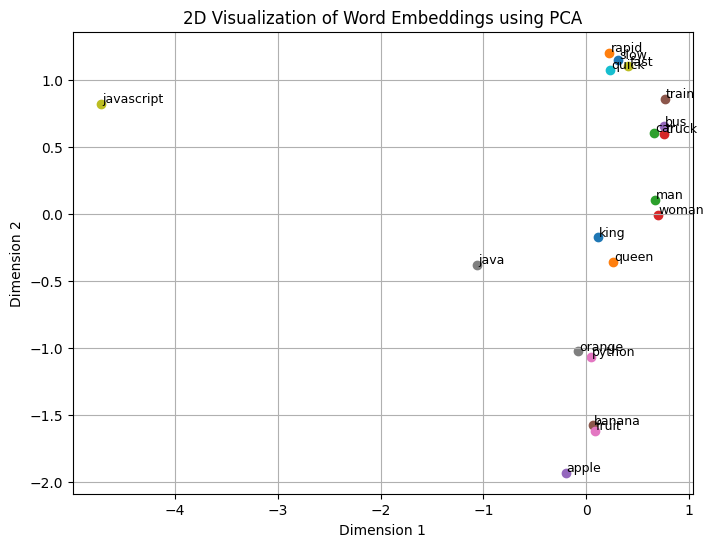

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_embeddings(words, model, method='pca'):
    """
    Visualize a set of words in 2D space using PCA or t-SNE.
    :param words: list of words to visualize
    :param model: loaded word embedding model
    :param method: 'pca' or 'tsne'
    """
    # Filter out OOV words
    in_vocab_words = [w for w in words if w in model.key_to_index]

    # Retrieve embeddings
    embeddings = [model[w] for w in in_vocab_words]

    # Reduce dimensionality
    if method.lower() == 'pca':
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)
        reduced = reducer.fit_transform(embeddings)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    # Plot
    plt.figure(figsize=(8, 6))
    for i, word in enumerate(in_vocab_words):
        x, y = reduced[i][0], reduced[i][1]
        plt.scatter(x, y)
        plt.text(x+0.01, y+0.01, word, fontsize=9)

    plt.title(f"2D Visualization of Word Embeddings using {method.upper()}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

if w2v_model:
    word_list = [
        "king", "queen", "man", "woman",
        "apple", "banana", "fruit", "orange",
        "fast", "quick", "slow", "rapid",
        "car", "truck", "bus", "train",
        "python", "java", "javascript"
    ]

    visualize_embeddings(word_list, w2v_model, method='pca')


**Task 3 Part 3 (20 Points): Designing a Novel Dissimilarity Metric**

While cosine similarity is a popular choice for comparing word embeddings,
sometimes we want to capture additional aspects of “dissimilarity” or “novelty”
that go beyond the simple angular difference in vector space.

**Examples of Alternative Metrics**:
1. **Euclidean Distance**:
   - Measures the straight-line distance between two vectors in embedding space.
   - If vectors are close in high-dimensional space, they are considered more “similar.”
   
2. **Word Entropy-based Dissimilarity**:
   - Incorporates how frequently (or infrequently) words appear in a corpus.
   - Rare words might get higher “importance” or might be considered more “dissimilar”
     if their contexts seldom overlap with common words.

3. **Semantic Contrast Measures**:
   - Rely on external knowledge (e.g., WordNet) to see if two words are synonyms, antonyms,
     or in different semantic domains.

**Our Custom Metric** (example approach):
- We’ll define a function that **combines Euclidean distance** in the embedding space
  with **an inverse frequency term**. The intuition is:
  - If two words are close in vector space, but one is extremely rare compared to the other,
    we might consider them more dissimilar.
  - Conversely, if both are close *and* have similar frequency ranks,
    they’re likely more semantically related.

Show:
- **Toggling** between cosine similarity, Euclidean distance, and our custom measure
  via a single function parameter.
- **Ranking** words by similarity/dissimilarity to a reference word.
- **Heatmap** visualization to compare multiple word pairs across different metrics.

Literature:  
[Camacho-Collados, J., & Pilehvar, M. T. (2018).  
*"From word to sense embeddings: A survey on vector representations of meaning."*  
Journal of Artificial Intelligence Research, 63, 743-788.]  

They discuss the importance of combining distributional similarity with lexical resources and frequency heuristics for certain tasks.

---

### **Our Implementation**
- Let `freq(w)` be a frequency-based lookup for the word `w`. For demonstration,
  we will approximate it with `model.get_vecattr(w, "count")` if available  
  (some Gensim embeddings store vocabulary counts), or use a fallback dictionary of frequencies.
- Let $$ D_{\text{euclid}}(\mathbf{v}_1, \mathbf{v}_2) $$ be the Euclidean distance between embeddings.
- Then, define the **custom dissimilarity** as:

$$
  \text{custom dissim}(w_1, w_2) = D_{\text{euclid}}(\mathbf{v_1}, \mathbf{v_2})
   \times \left| \frac{1}{\log(\text{freq}(w_1)+2)} - \frac{1}{\log(\text{freq}(w_2)+2)} \right|
$$

We use \$$( \log(\text{freq} + 2) \) $$ to avoid division by zero and to keep it non-linear.  
This is just one possible design. The factor  

$$
\left| \frac{1}{\log(\text{freq}(w_1)+2)} - \frac{1}{\log(\text{freq}(w_2)+2)} \right|
$$

captures how different the words are in terms of rarity. If both have similar frequencies,  
that factor becomes small, thus the distance remains mostly about Euclidean difference.  
If one word is rare and the other is common, the factor becomes larger, amplifying the dissimilarity.

In [39]:
import numpy as np

def euclidean_distance(vec1, vec2):
    """Compute the Euclidean distance between two vectors."""
    return np.linalg.norm(vec1 - vec2)

def custom_dissim(w1, w2, model, freq_dict=None):
    """
    Custom dissimilarity that combines Euclidean distance in embedding space
    with difference in inverse log-frequency.

    :param w1, w2: Words to compare
    :param model: Loaded word2vec model for retrieving embeddings
    :param freq_dict: A dictionary {word: frequency} or method to get word frequency.
                      If None, we use a fallback frequency (e.g. 1) for unknown words.
    :return: A float representing dissimilarity (higher => more dissimilar).
    """
    vec1 = model[w1]
    vec2 = model[w2]
    base_dist = euclidean_distance(vec1, vec2)

    # Retrieve frequencies from a dictionary or fallback to 1
    f1 = freq_dict[w1] if freq_dict and w1 in freq_dict else 1
    f2 = freq_dict[w2] if freq_dict and w2 in freq_dict else 1

    # Inverse log frequency difference
    diff_freq = abs( (1.0 / np.log(f1 + 2.0)) - (1.0 / np.log(f2 + 2.0)) )
    return base_dist * diff_freq

def compare_words(w1, w2, model, metric="cosine", freq_dict=None):
    """
    Compare two words using the specified metric: 'cosine', 'euclidean', or 'custom'.
    """
    if w1 not in model.key_to_index or w2 not in model.key_to_index:
        return None # OOV

    vec1 = model[w1]
    vec2 = model[w2]

    if metric == "cosine":
        # We'll reuse the function from Part 2
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot_product / (norm1 * norm2)
    elif metric == "euclidean":
        return euclidean_distance(vec1, vec2)
    elif metric == "custom":
        return custom_dissim(w1, w2, model, freq_dict)
    else:
        raise ValueError("metric must be one of: 'cosine', 'euclidean', or 'custom'")

We can pick a reference word and compute how other words rank relative to it using
our three different metrics. For similarity-based metrics (like cosine),
higher is more similar. For dissimilarity-based metrics (like Euclidean or custom),
lower is more similar (because distance is smaller).

To unify this for ranking, we can define separate “similarity” or “distance”
functions or just be consistent about inverting one if needed.
In the example below, we’ll demonstrate ranking by “most similar” for cosine,
and “least distance” for Euclidean/custom.
We just need to clarify what we’re sorting by.

In [40]:
def rank_words(reference_word, candidates, model, metric="cosine", freq_dict=None, top_n=5):
    """
    Ranks candidate words based on similarity or dissimilarity to a reference word,
    depending on the chosen metric. Returns the top_n results (lowest distance or highest similarity).
    """
    results = []

    for w in candidates:
        if w == reference_word:
            continue
        score = compare_words(reference_word, w, model, metric, freq_dict)
        if score is not None:
            results.append((w, score))

    # For cosine: higher => more similar, so sort descending
    if metric == "cosine":
        results.sort(key=lambda x: x[1], reverse=True)
    else:
        # For 'euclidean' or 'custom': lower => more similar, so sort ascending
        results.sort(key=lambda x: x[1])

    return results[:top_n]

if w2v_model:
    # Example usage
    reference = "cat"
    word_list = ["dog","lion","tiger","table","chair","kitten","puppy","plant","mouse","car"]

    freq_dict = {
        "cat": 500,
        "dog": 600,
        "lion": 100,
        "tiger": 90,
        "table": 1000,
        "chair": 1200,
        "kitten": 300,
        "puppy": 400,
        "plant": 700,
        "mouse": 450,
        "car": 2000
    }

    print("Ranking by Cosine Similarity to 'cat':")
    print(rank_words(reference, word_list, w2v_model, metric="cosine", freq_dict=freq_dict))

    print("\nRanking by Euclidean Distance to 'cat':")
    print(rank_words(reference, word_list, w2v_model, metric="euclidean", freq_dict=freq_dict))

    print("\nRanking by Custom Dissimilarity to 'cat':")
    print(rank_words(reference, word_list, w2v_model, metric="custom", freq_dict=freq_dict))

Ranking by Cosine Similarity to 'cat':
[('dog', 0.76094574), ('kitten', 0.7464984), ('puppy', 0.70754534), ('tiger', 0.5172962), ('mouse', 0.46566278)]

Ranking by Euclidean Distance to 'cat':
[('dog', 2.0815337), ('kitten', 2.3034523), ('puppy', 2.4245925), ('mouse', 3.2288268), ('tiger', 3.2323527)]

Ranking by Custom Dissimilarity to 'cat':
[('mouse', 0.008910437111994926), ('dog', 0.009500496058699865), ('puppy', 0.01444422437172073), ('kitten', 0.03296322328674975), ('plant', 0.03481235839234141)]


We can also visualize how multiple words compare to each other by plotting
a heatmap of metric scores. For example, we’ll pick a set of words, compute
either “cosine similarity” or “custom dissimilarity” for every pair, and then
display that in a matrix form.

**Steps**:
1. Construct a 2D matrix M where M[i,j] = similarity/dissimilarity between word i and word j.
2. Use matplotlib/seaborn to plot a heatmap.
3. Interpret the resulting clusters or patterns:
   - For similarity, darker might mean higher similarity;
   - For dissimilarity, darker might mean more distance.


Heatmap - Cosine Similarities:


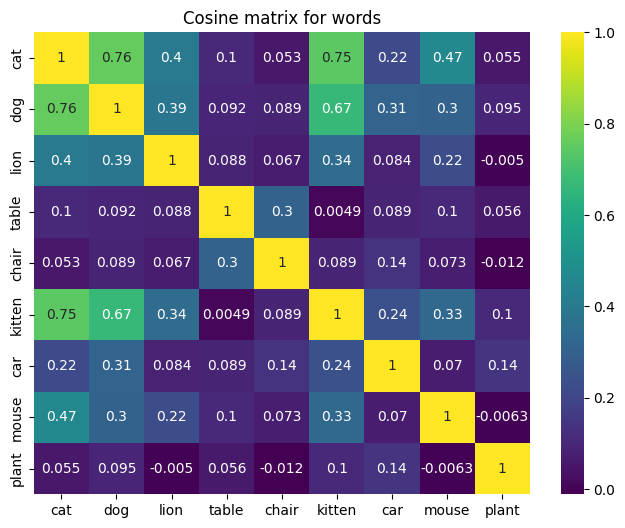


Heatmap - Custom Dissimilarities:


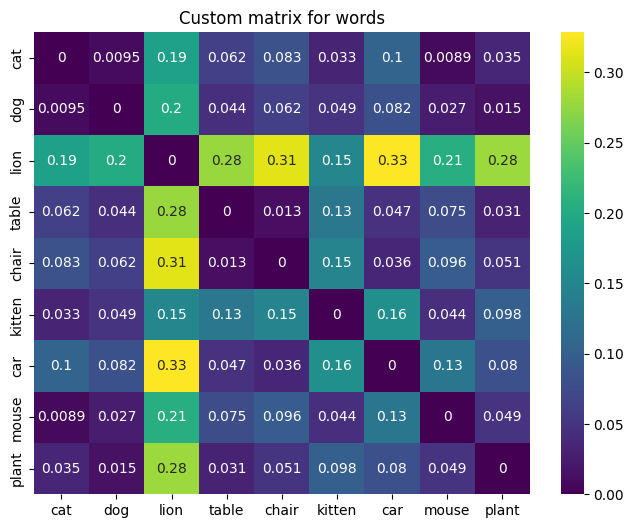

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(words, model, metric="cosine", freq_dict=None):
    """
    Plot a heatmap of pairwise metric scores for the given list of words.
    """
    # Filter out OOV
    valid_words = [w for w in words if w in model.key_to_index]
    size = len(valid_words)

    scores = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            if i == j:
                # Same word comparison
                scores[i, j] = 1.0 if metric=="cosine" else 0.0
            else:
                val = compare_words(valid_words[i], valid_words[j], model, metric, freq_dict)
                # For distance-based metrics, we store val as is
                # For cosine, we store 1 - cos to interpret it as "distance" in the heatmap, OR keep cos directly
                scores[i, j] = val if val is not None else 0.0

    plt.figure(figsize=(8,6))
    sns.heatmap(scores, xticklabels=valid_words, yticklabels=valid_words, annot=True, cmap="viridis")
    plt.title(f"{metric.capitalize()} matrix for words")
    plt.show()

if w2v_model:
    words_to_compare = ["cat","dog","lion","table","chair","kitten","car","mouse","plant"]

    print("\nHeatmap - Cosine Similarities:")
    plot_heatmap(words_to_compare, w2v_model, metric="cosine", freq_dict=freq_dict)

    print("\nHeatmap - Custom Dissimilarities:")
    plot_heatmap(words_to_compare, w2v_model, metric="custom", freq_dict=freq_dict)

**Concluding Observations**

From the ranking results and heatmaps, we can see how each metric
(Cosine Similarity, Euclidean Distance, and our Custom Dissimilarity)
captures word relationships differently:

1. **Cosine Similarity**  
   - Focuses solely on the angle between vectors.  
   - Ranks words like "dog," "kitten," and "puppy" as most similar to "cat,"
     which aligns with our expectation that these animals share many
     contextual features in language use.  
   - The heatmap shows near-diagonal areas of high similarity for semantically
     related terms (e.g., "cat" and "dog").

2. **Euclidean Distance**  
   - Measures raw spatial distance.  
   - Also puts "dog," "kitten," and "puppy" close to "cat," but the exact
     ordering of these neighbors can differ from cosine due to differences
     in the magnitude of the vectors.  
   - While the resulting top-5 “closest” words mostly overlap with cosine’s picks,
     certain pairs might swap rank because vector magnitudes affect
     Euclidean distance more than angles alone.

3. **Custom Dissimilarity (Euclidean × Frequency Factor)**  
   - Introduces a frequency-based penalty or boost.  
   - Interestingly, **“mouse”** ranks as the closest to “cat” under this metric,
     indicating that although “mouse” and “cat” may not be extremely close in
     raw embedding space, their frequency profiles (in this example’s data)
     reduce their overall dissimilarity.  
   - “Plant” also appears in the top list, which may reflect how its distance
     plus frequency combination ends up numerically small. If both “cat”
     and “plant” have moderate or similar frequency logs, the custom factor
     might not inflate their distance as much as it would between words
     with drastically different frequency distributions.  
   - This reveals how an additional frequency dimension can shift the
     interpretation of “closeness” toward or away from certain pairs.

**What Do These Differences Mean?**  
- **Cosine** and **Euclidean** measure purely geometric properties of the
  embeddings (angle vs. raw distance).  
- **Custom Metric** attempts to highlight or penalize frequency discrepancies.
  This can be valuable if one wants to downplay or amplify certain relationships
  based on how commonly (or rarely) words appear in text corpora.  

**Practical Takeaways**  
- **Task-Driven Choice**: If you want a traditional notion of semantic similarity
  (e.g., synonyms or related concepts), cosine or Euclidean might suffice.  
- **Contextual Nuances**: If frequency or domain differences matter (e.g.,
  distinguishing rare medical terms vs. everyday words), a custom approach
  can be more insightful.  
- **Visual Clustering**: The heatmaps highlight which words form tighter groups
  under each metric. This can guide you in choosing or refining a metric that
  aligns best with your domain or application needs.

Overall, these metrics provide **complementary perspectives** on "closeness" in
embedding space. By allowing users to switch between them, we gain richer
insights into how words relate in both distributional geometry
and real-world usage frequency.